# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges) `graphs/xtalname_node_labels.npy`

In [156]:
using PorousMaterials # use master branch. ]add PorousMaterials#master
using DataFrames
using PyPlot
using NPZ
using LightGraphs
using LinearAlgebra
using Logging
using Printf

global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x00000029) open, 0 bytes waiting))), Info, Dict{Any,Int64}())

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [89]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "xtals")

"/home/cokes/mpn_charges/build_graphs/xtals"

In [90]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"  
 "ABAVOP_clean"  
 "ABEXIQ_clean"  
 "ABEXOW_clean"  
 "ABEXUC_clean"  
 "ABEYAJ_clean"  
 "ABEYIR"        
 "ABIYIV"        
 "ABUWOJ_clean"  
 "ACAKUM"        
 "ACALIB_clean"  
 "ACODED"        
 "ACOLIP_clean"  
 ⋮               
 "ZILBAZ_clean"  
 "ZILBED_clean"  
 "ZIMJOW_clean"  
 "ZISYAD_clean"  
 "ZNGLUD01_clean"
 "ZNGLUD_clean"  
 "ZURQOS_clean"  
 "Zn-DOBDC"      
 "ZnBDC"         
 "ZnBDCdabco"    
 "ZnHBDC"        
 "ZnMOF-74"      

### find unique atomic species

In [91]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    framework = Framework(xtalname * ".cif")
    for a in unique(framework.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [52]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    framework = Framework(xtalname * ".cif")
    for a in unique(framework.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 116
  :Al => 33
  :Re => 8
  :Be => 2
  :Cr => 20
  :Na => 39
  :Sb => 2
  :Ni => 121
  :S  => 221
  :Ru => 10
  :Tm => 19
  :W  => 16
  :Nd => 91
  :O  => 2591
  :Th => 4
  :F  => 83
  :Co => 285
  :Gd => 75
  :Rh => 2
  :Pu => 1
  :Ca => 44
  :N  => 1765
  :Yb => 27
  :As => 2
  :Se => 2
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [83]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Ir,1
3,Be,2
4,Sb,2
5,Rh,2
6,As,2


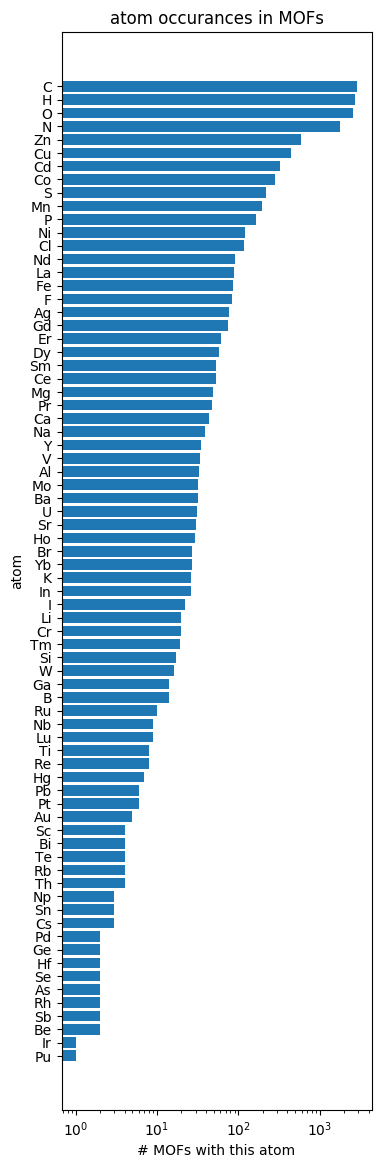

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [84]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [85]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C 
 :H 
 :O 
 :N 
 :Zn
 :Cu
 :Cd
 :Co
 :S 
 :Mn
 :P 
 :Ni
 :Cl
 ⋮  
 :Sn
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Se
 :Hf
 :Ge
 :Pd
 :Pu
 :Ir

In [92]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 13
  :Al => 30
  :Re => 51
  :Be => 65
  :Cr => 41
  :Na => 27
  :Sb => 66
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 43
  :W  => 45
  :Nd => 14
  :O  => 3
  :Th => 57
  :F  => 17
  :Co => 8
  :Gd => 19
  :Rh => 67
  :Pu => 73
  :Ca => 26
  :N  => 4
  :Yb => 36
  :As => 68
  :Se => 69
  ⋮   => ⋮

### write graph structure, edge features, node features, and node labels to file for each MOF

In [124]:
isdir("graphs") ? nothing : mkdir("graphs")

In [ ]:
@info "making edge list zero-based indexed for Python"

for xtalname in xtalnames
    framework = Framework(xtalname * ".cif")
    @assert ! all(framework.charges.q .== 0)
    infer_bonds!(framework, true)
    framework.bonds
    @assert nv(framework.bonds) == framework.atoms.n_atoms

    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, framework.atoms.n_atoms, length(ATOMS))
    for (i, atom) in enumerate(framework.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == framework.atoms.n_atoms
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(framework.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), x_ν)

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(framework.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        dxf = framework.atoms.xf[:, i] - framework.atoms.xf[:, j]
        nearest_image!(dxf)
        r = norm(framework.box.f_to_c * dxf)
        @debug "$i $j $cartesian_dist_between_atoms"
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end